##  <font color=MediumSlateBlue>Importing Libraries</font> ##

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!ls

gdrive	sample_data


####  <font color=SlateBlue>CNN</font> ####

In [3]:
import torch
import torch.optim as optim
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

##  <font color=MediumSlateBlue>Classes and Functions</font> ##

####  <font color=SlateBlue>Transfer Sub-Net Encoder Module</font> ####

In [4]:
class TransferSubNetEncoder(nn.Module):
  def __init__(self, requires_grad=False):
    super(TransferSubNetEncoder, self).__init__()

    vgg = self.modifyVGG()

    vgg_layers = list(vgg.children())
    self.slice1 = nn.Sequential(*vgg_layers[0:6])  
    self.slice2 = nn.Sequential(*vgg_layers[6:13])  
    self.slice3 = nn.Sequential(*vgg_layers[13:26])  
    self.slice4 = nn.Sequential(*vgg_layers[26:30])  

  def modifyVGG(self):
    vgg = models.vgg19_bn(pretrained=True, progress=False).features

    # Freeze all VGG parameters since we’re only optimizing the target image
    for param in vgg.parameters():
      param.requires_grad_(False)

    for i, layer in vgg.named_children():
      if isinstance(layer, torch.nn.MaxPool2d):
        vgg[int(i)] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

    return vgg

  def forward(self, input):
    out1 = self.slice1(input)
    out2 = self.slice2(out1)
    out3 = self.slice3(out2)
    out4 = self.slice4(out3)
    return {'Slice1':out1, 'Slice2':out2, 'Slice3':out3, 'Encoder':out4}


####  <font color=SlateBlue>Transfer Sub-Net Decoder Module</font> ####

In [5]:
class ConvBachNormReLU(nn.Module):
  def __init__(self, in_channels_size, out_channels_size, 
               kernel_size=(3, 3), stride_size=(1, 1), padding_size=(1, 1)):
    super(ConvBachNormReLU, self).__init__()

    conv_layer = nn.Conv2d(in_channels=in_channels_size,
                           out_channels=out_channels_size,
                           kernel_size=kernel_size,
                           stride=stride_size,
                           padding=padding_size)
    
    bn_layer = nn.BatchNorm2d(out_channels_size, 
                              eps=1e-05, 
                              momentum=0.1, 
                              affine=True, 
                              track_running_stats=True)

    activation_layer = nn.ReLU(inplace=True)

    self.unit = nn.Sequential(conv_layer, 
                              bn_layer, 
                              activation_layer)
      
  def forward(self, input): return self.unit(input)

In [6]:
class TransferSubNetDecoder(nn.Module):
  def __init__(self):
    super(TransferSubNetDecoder, self).__init__()

    self.slice_4 = nn.Sequential(ConvBachNormReLU(512, 256),
                                 nn.Upsample(scale_factor=2, mode='nearest'))
    
    self.slice_3 = nn.Sequential(ConvBachNormReLU(256, 256),
                                 ConvBachNormReLU(256, 256),
                                 ConvBachNormReLU(256, 256),
                                 ConvBachNormReLU(256, 128),
                                 nn.Upsample(scale_factor=2, mode='nearest'))
    
    self.slice_2 = nn.Sequential(ConvBachNormReLU(128, 128),
                                 ConvBachNormReLU(128, 64),
                                 nn.Upsample(scale_factor=2, mode='nearest'))
    
    self.slice_1 = nn.Sequential(ConvBachNormReLU(64, 64),
                                 ConvBachNormReLU(64, 3))

  def forward(self, encoder_outputs):
    out4 = self.slice_4(encoder_outputs['Encoder'])

    in3 = out4 + encoder_outputs['Slice3']
    out3 = self.slice_3(in3)

    in2 = out3 + encoder_outputs['Slice2']
    out2 = self.slice_2(in2)

    in1 = out2 + encoder_outputs['Slice1']
    return self.slice_1(in1)

####  <font color=SlateBlue>Transfer Sub-Net</font> ####

In [7]:
def calc_mean_std(features, eps=1e-5):
  # eps is a small value added to the variance to avoid divide-by-zero.
  size = features.size()
  assert (len(size) == 4)
  N, C = size[:2]

  features_var = features.view(N, C, -1).var(dim=2) + eps
  features_std = features_var.sqrt().view(N, C, 1, 1)

  features_mean = features.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)

  return features_mean, features_std

def AdaIN(content_features, style_features):
  assert (content_features.size()[:2] == style_features.size()[:2])
  size = content_features.size()

  style_mean, style_std = calc_mean_std(style_features)
  content_mean, content_std = calc_mean_std(content_features)

  normalized_features = (content_features - content_mean.expand(size)) / content_std.expand(size)

  return normalized_features * style_std.expand(size) + style_mean.expand(size)

In [8]:
class TransferSubNet(nn.Module):
  def __init__(self):
    super(TransferSubNet, self).__init__()

    self.encoder = TransferSubNetEncoder()
    self.decoder = TransferSubNetDecoder()

  def forward(self, R, T_prime):
    style_features = self.encoder(R)
    content_features = self.encoder(T_prime)

    decoder_in = AdaIN(content_features['Encoder'], style_features['Encoder'])
    
    return self.decoder({'Slice1':content_features['Slice1'], 'Slice2':content_features['Slice2'], 'Slice3':content_features['Slice3'], 'Encoder':decoder_in})



##  <font color=SlateBlue>Train Transfer Sub-Net</font> ##

###  <font color=SlateBlue>perceptual Loss </font> ###

In [9]:
class VGGLossNet(nn.Module):
  def __init__(self, requires_grad=False):
    super(VGGLossNet, self).__init__()

    vgg = self.modifyVGG()

    vgg_layers = list(vgg.children())
    self.conv1_1 = nn.Sequential(*vgg_layers[0:1])  
    self.conv2_1 = nn.Sequential(*vgg_layers[1:6])  
    self.conv3_1 = nn.Sequential(*vgg_layers[6:11])  
    self.conv4_1 = nn.Sequential(*vgg_layers[11:20]) 
    self.conv4_2 = nn.Sequential(*vgg_layers[20:22])
    self.conv5_1 = nn.Sequential(*vgg_layers[22:29])  

  def modifyVGG(self):
    vgg = models.vgg19(pretrained=True, progress=False).features

    # Freeze all VGG parameters since we’re only optimizing the target image
    for param in vgg.parameters():
      param.requires_grad_(False)
    return vgg

  def forward(self, input):
    conv1_1 = self.conv1_1(input)
    conv2_1 = self.conv2_1(conv1_1)
    conv3_1 = self.conv3_1(conv2_1)
    conv4_1 = self.conv4_1(conv3_1)
    conv4_2 = self.conv4_2(conv4_1)
    conv5_1 = self.conv5_1(conv4_2)
    return {'Conv1_1':conv1_1, 'Conv2_1':conv2_1, 'Conv3_1':conv3_1, 'Conv4_1':conv4_1, 'Conv4_2':conv4_2, 'Conv5_1':conv5_1}

In [10]:
#https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
#https://medium.com/udacity-pytorch-challengers/style-transfer-using-deep-nural-network-and-pytorch-3fae1c2dd73e

def gramMat(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

def calcStylLoss(targetFeatures, styleFeatures, styleWeights):
  loss = 0.0
  for layer in styleWeights:
    # targFeature = targetFeatures[layer]
    # styleFeature = styleFeatures[layer]

    trgGram = gramMat(targetFeatures[layer])
    stylGram = gramMat(styleFeatures[layer])#.detach()

    # lossTmp = styleWeights[layer] * F.mse_loss(stylGram, trgGram)
    # loss += lossTmp
    loss += styleWeights[layer] * F.mse_loss(stylGram, trgGram)
  return loss



In [11]:
batch_size = 4
num_epochs = 2

In [12]:
%run ./gdrive/MyDrive/Deep/data_prep.ipynb
dp = Data_prep()
X_train, X_val, Y_train, Y_val = dp.load_data()

Streaming output truncated to the last 5000 lines.
 extracting: train2017/000000234031.jpg  
 extracting: train2017/000000563584.jpg  
 extracting: train2017/000000276069.jpg  
 extracting: train2017/000000401194.jpg  
 extracting: train2017/000000502089.jpg  
 extracting: train2017/000000192183.jpg  
 extracting: train2017/000000425127.jpg  
 extracting: train2017/000000126766.jpg  
 extracting: train2017/000000324161.jpg  
 extracting: train2017/000000452746.jpg  
 extracting: train2017/000000423782.jpg  
 extracting: train2017/000000546343.jpg  
 extracting: train2017/000000249290.jpg  
 extracting: train2017/000000025529.jpg  
 extracting: train2017/000000316928.jpg  
 extracting: train2017/000000337866.jpg  
 extracting: train2017/000000547768.jpg  
 extracting: train2017/000000423162.jpg  
 extracting: train2017/000000224149.jpg  
 extracting: train2017/000000117841.jpg  
 extracting: train2017/000000251660.jpg  
 extracting: train2017/000000110997.jpg  
 extracting: train2017/00

In [13]:
trans = T.Compose([
          T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ])
train_data = COCODataset(X_train, Y_train, transform = trans)
val_data = COCODataset(X_val, Y_val, transform = trans)

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)

In [14]:
dataloader_iterator = iter(val_loader)
validation_sample = next(dataloader_iterator)
inputImg, refImg = validation_sample

In [15]:
print(len(train_data))

4929


In [16]:
refImg.shape

torch.Size([4, 3, 256, 256])

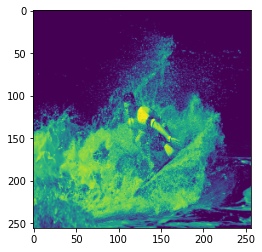

In [17]:
plt.imshow(refImg[0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


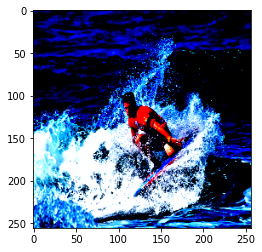

In [18]:
plt.imshow(np.transpose(refImg[0], (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


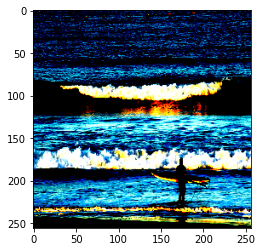

In [19]:
plt.imshow(np.transpose(inputImg[0], (1,2,0)))

In [20]:
transNet = TransferSubNet().cuda().double()
# transNet = torch.load("./gdrive/MyDrive/Deep/transNet_checkpoint.pth.tar").cuda().double()
lossNet = VGGLossNet().cuda().double()
optimizer = optim.Adam(transNet.parameters(), lr =0.001)
styleWeights = {'Conv1_1': 1.,
                 'Conv2_1': 0.75,
                 'Conv3_1': 0.2,
                 'Conv4_1': 0.2,
                 'Conv5_1': 0.2}

perceptualCoeff = 0.2
reconstCoeff = 0.8
contCoeff = 1
stylCoeff = 1e6

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


Epoch 1 has started......
iteration # 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


iteration #0 10.183040587073233


No handles with labels found to put in legend.


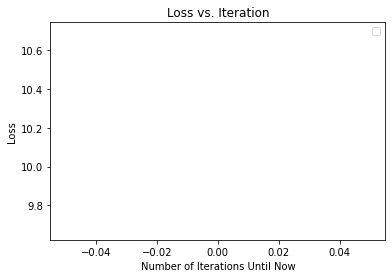

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


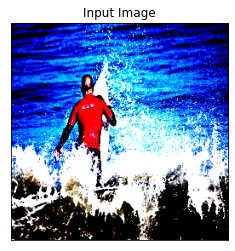

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


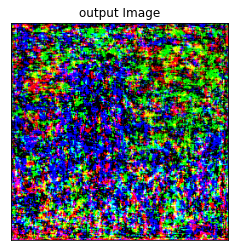

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


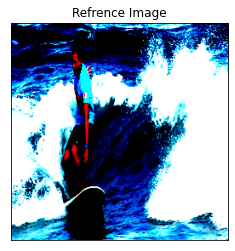

iteration # 1
iteration #1 7.5378155111002
iteration # 2
iteration #2 8.044245266433283
iteration # 3
iteration #3 4.91011336149637
iteration # 4
iteration #4 12.929686136595834
iteration # 5
iteration #5 5.5314497320949165
iteration # 6
iteration #6 10.61235515244903
iteration # 7
iteration #7 14.297831446695982
iteration # 8
iteration #8 5.498972202732121
iteration # 9
iteration #9 6.535043032117942
iteration # 10
iteration #10 3.714089986804941
iteration # 11
iteration #11 13.429542990679712
iteration # 12
iteration #12 14.232475892717767
iteration # 13
iteration #13 5.51546360595799
iteration # 14
iteration #14 6.839077317066361
iteration # 15
iteration #15 6.480840433863482
iteration # 16
iteration #16 6.336863692414318
iteration # 17
iteration #17 5.409133522779447
iteration # 18
iteration #18 4.749702160797853
iteration # 19
iteration #19 14.417138970011349
iteration # 20
iteration #20 5.01622614543639
iteration # 21
iteration #21 9.43949433856889
iteration # 22
iteration #22 4.

No handles with labels found to put in legend.


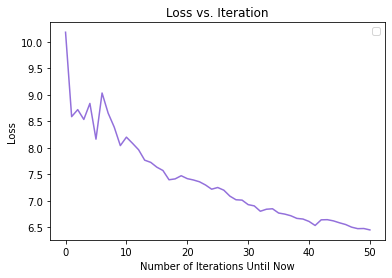

iteration # 101
iteration #101 4.761334582801685
iteration # 102
iteration #102 5.4342011111527695
iteration # 103
iteration #103 4.454762638328108
iteration # 104
iteration #104 11.297272489492217
iteration # 105
iteration #105 6.558744204932102
iteration # 106
iteration #106 3.4755002547925815
iteration # 107
iteration #107 4.9737975985495675
iteration # 108
iteration #108 3.874223567793294
iteration # 109
iteration #109 5.727187578188876
iteration # 110
iteration #110 7.449712419792563
iteration # 111
iteration #111 8.649800443603164
iteration # 112
iteration #112 3.5063666483897404
iteration # 113
iteration #113 6.677023001738263
iteration # 114
iteration #114 6.322592536636126
iteration # 115
iteration #115 5.025759825212075
iteration # 116
iteration #116 6.101558653942531
iteration # 117
iteration #117 7.598665832016562
iteration # 118
iteration #118 8.86200666008198
iteration # 119
iteration #119 7.0085671881454665
iteration # 120
iteration #120 4.997290672505289
iteration # 121

No handles with labels found to put in legend.


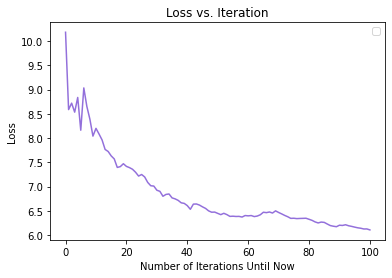

iteration # 201
iteration #201 2.675423373134956
iteration # 202
iteration #202 4.387172569895368
iteration # 203
iteration #203 3.763313936393094
iteration # 204
iteration #204 3.6441855195092066
iteration # 205
iteration #205 3.378862581515076
iteration # 206
iteration #206 16.307750028303694
iteration # 207
iteration #207 3.552690111411263
iteration # 208
iteration #208 9.139721702690618
iteration # 209
iteration #209 3.332202833154247
iteration # 210
iteration #210 2.764062359362833
iteration # 211
iteration #211 8.961181339832219
iteration # 212
iteration #212 5.291977130809851
iteration # 213
iteration #213 9.149589148695041
iteration # 214
iteration #214 4.998948327844445
iteration # 215
iteration #215 6.491439926176702
iteration # 216
iteration #216 3.574128394482224
picture problem!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
iteration # 217
iteration #217 4.246940326691827
iteration # 218
iteration #218 11.703562951066298
iteration # 219
iteration #219 4.137083960109202
iteration

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


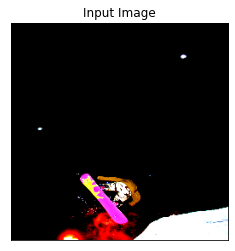

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


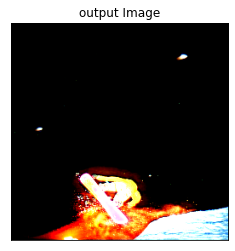

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


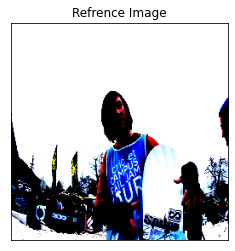

iteration # 251
iteration #251 3.944688394577935
iteration # 252
iteration #252 5.213276562910758
iteration # 253
iteration #253 3.5364368249989298
iteration # 254
iteration #254 4.240264359439857
iteration # 255
iteration #255 5.893401835024701
iteration # 256
iteration #256 4.087289322397329
iteration # 257
iteration #257 6.283562277524891
iteration # 258
iteration #258 4.0825935164313165
iteration # 259
iteration #259 3.4041828942296095
iteration # 260
iteration #260 5.079479308803158
iteration # 261
iteration #261 4.148496592556273
iteration # 262
iteration #262 2.924930517983775
iteration # 263
iteration #263 3.4831292083614045
iteration # 264
iteration #264 4.480465614156293
iteration # 265
iteration #265 4.262034027225356
iteration # 266
iteration #266 3.900851022715095
iteration # 267
iteration #267 5.389463283811492
iteration # 268
iteration #268 4.770346937068474
iteration # 269
iteration #269 5.14253947800091
iteration # 270
iteration #270 2.9273481864750384
iteration # 271


No handles with labels found to put in legend.


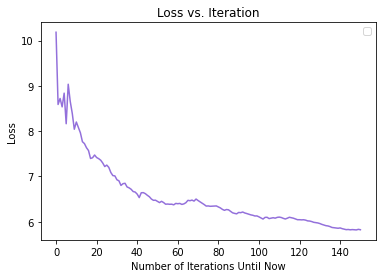

iteration # 301
iteration #301 5.1646172697436
iteration # 302
iteration #302 5.710027774568587
iteration # 303
iteration #303 4.223666527069707
iteration # 304
iteration #304 5.947954689554656
iteration # 305
iteration #305 4.5802534351242565
iteration # 306
iteration #306 6.460880895444385
iteration # 307
iteration #307 3.8093770998882204
iteration # 308
iteration #308 3.950488601170678
iteration # 309
iteration #309 4.6013247462743845
iteration # 310
iteration #310 5.353397846262462
iteration # 311
iteration #311 5.953902666829011
iteration # 312
iteration #312 3.407802112309911
iteration # 313
iteration #313 14.76247158759929
iteration # 314
iteration #314 6.55904834468712
iteration # 315
iteration #315 3.557719971126216
iteration # 316
iteration #316 3.2702222865556676
iteration # 317
iteration #317 6.990267643058717
iteration # 318
iteration #318 3.7203488374581513
iteration # 319
iteration #319 4.288585870299023
iteration # 320
iteration #320 6.102063511374011
iteration # 321
it

No handles with labels found to put in legend.


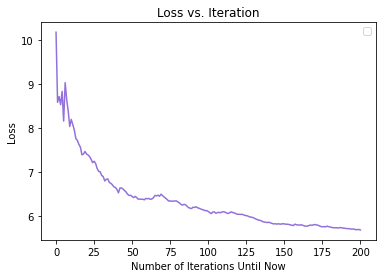

iteration # 401
iteration #401 4.51866655221424
iteration # 402
iteration #402 5.562886312505907
iteration # 403
iteration #403 7.130672636419431
iteration # 404
iteration #404 3.7250125252302557
iteration # 405
iteration #405 5.74999006016626
iteration # 406
iteration #406 4.092434222370618
iteration # 407
iteration #407 3.729170519582287
iteration # 408
iteration #408 9.302507097305119
iteration # 409
iteration #409 3.705976403307553
iteration # 410
iteration #410 13.532200673092396
iteration # 411
iteration #411 3.3561856186749384
iteration # 412
iteration #412 2.78309433883048
iteration # 413
iteration #413 3.2712027960605696
iteration # 414
iteration #414 3.2937512756776486
iteration # 415
iteration #415 4.099884272115912
iteration # 416
iteration #416 4.530899089080568
iteration # 417
iteration #417 4.035884296792174
iteration # 418
iteration #418 2.9895990116591453
iteration # 419
iteration #419 6.707253964197237
iteration # 420
iteration #420 4.559470525037203
iteration # 421
i

No handles with labels found to put in legend.


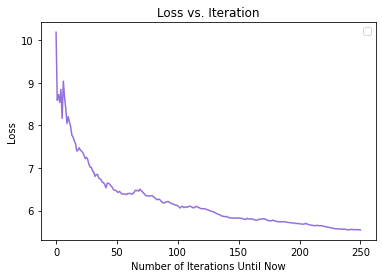

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


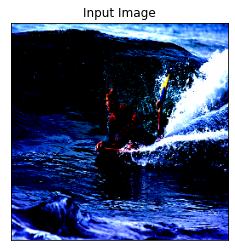

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


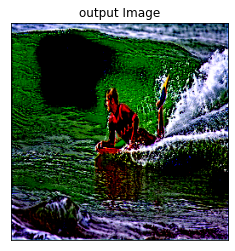

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


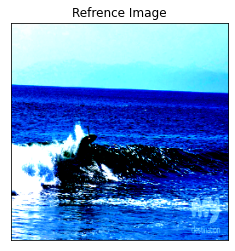

iteration # 501
iteration #501 5.731870702680364
iteration # 502
iteration #502 5.3927644621817805
iteration # 503
iteration #503 4.039291336477455
iteration # 504
iteration #504 3.1482673514722794
iteration # 505
iteration #505 4.149262896500982
iteration # 506
iteration #506 2.922574595742729
iteration # 507
iteration #507 4.430884335416201
iteration # 508
iteration #508 4.716795495788036
iteration # 509
iteration #509 5.700703958407562
iteration # 510
iteration #510 2.768999393894943
iteration # 511
iteration #511 3.596371720660585
iteration # 512
iteration #512 7.562113048431075
iteration # 513
iteration #513 3.336980917062303
iteration # 514
iteration #514 12.907546643839343
iteration # 515
iteration #515 4.5616392500152365
iteration # 516
iteration #516 6.062253796010146
iteration # 517
iteration #517 3.914330486527035
iteration # 518
iteration #518 3.6217879954947296
iteration # 519
iteration #519 3.1398560115646665
iteration # 520
iteration #520 3.2737330992512796
iteration # 5

No handles with labels found to put in legend.


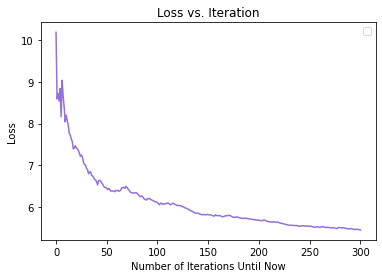

iteration # 601
iteration #601 7.574401009969907
iteration # 602
iteration #602 2.992718616259874
iteration # 603
iteration #603 5.25297156398903
iteration # 604
iteration #604 3.1868848302289923
iteration # 605
iteration #605 6.186992834431384
iteration # 606
iteration #606 2.499950930617943
iteration # 607
iteration #607 3.8928427774403547
iteration # 608
iteration #608 4.673723837375935
iteration # 609
iteration #609 5.082867506000007
iteration # 610
iteration #610 4.232004728307345
iteration # 611
iteration #611 3.751498921496216
iteration # 612
iteration #612 3.7858702258708603
iteration # 613
iteration #613 4.040907162991868
iteration # 614
iteration #614 4.055675773785805
iteration # 615
iteration #615 3.5239491753707783
iteration # 616
iteration #616 5.5995724741288955
iteration # 617
iteration #617 3.491860635025148
iteration # 618
iteration #618 4.517771454777708
iteration # 619
iteration #619 2.701028684838452
iteration # 620
iteration #620 3.9709210889208295
iteration # 621

No handles with labels found to put in legend.


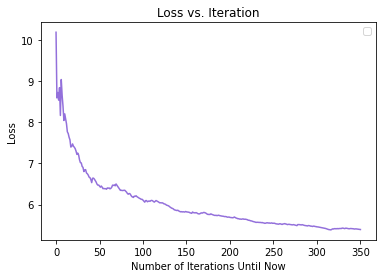

iteration # 701
iteration #701 3.003897912620525
iteration # 702
iteration #702 7.193791065314768
iteration # 703
iteration #703 2.955713120337272
iteration # 704
iteration #704 3.7002151972915485
iteration # 705
iteration #705 4.619032603435859
iteration # 706
iteration #706 4.99927722550398
iteration # 707
iteration #707 4.397476170582711
iteration # 708
iteration #708 3.599322311806775
iteration # 709
iteration #709 4.317211461306345
iteration # 710
iteration #710 4.563321967139424
iteration # 711
iteration #711 4.185548840869131
iteration # 712
iteration #712 3.9611223422732493
iteration # 713
iteration #713 3.9399207804364225
iteration # 714
iteration #714 6.488103642365989
iteration # 715
iteration #715 4.432266963914381
iteration # 716
iteration #716 4.951803201775265
iteration # 717
iteration #717 10.003555677218642
iteration # 718
iteration #718 5.002585822449293
iteration # 719
iteration #719 5.689695856020673
iteration # 720
iteration #720 2.5628497030111963
iteration # 721


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


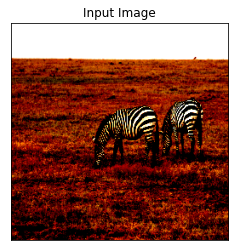

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


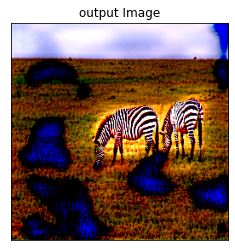

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


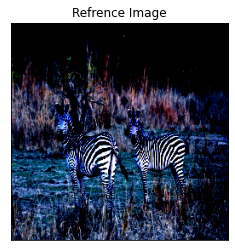

iteration # 751
iteration #751 3.874242508675449
iteration # 752
iteration #752 5.135649216260743
iteration # 753
iteration #753 7.6454145658196335
iteration # 754
iteration #754 3.706465497498863
iteration # 755
iteration #755 7.310542746498527
iteration # 756
iteration #756 3.192447859051887
iteration # 757
iteration #757 2.0752480591399136
iteration # 758
iteration #758 3.3476532343682304
iteration # 759
iteration #759 4.958607886781075
iteration # 760
iteration #760 4.034390580723101
iteration # 761
iteration #761 8.031935938608903
iteration # 762
iteration #762 2.667286718882032
iteration # 763
iteration #763 3.337148926574799
iteration # 764
iteration #764 3.1474287427039394
iteration # 765
iteration #765 6.745435630370054
iteration # 766
iteration #766 2.916710446204136
iteration # 767
iteration #767 9.594232074416285
iteration # 768
iteration #768 3.3532322376452726
iteration # 769
iteration #769 5.5729368391297465
iteration # 770
iteration #770 6.246253221174548
iteration # 77

No handles with labels found to put in legend.


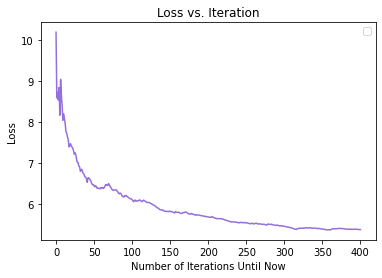

iteration # 801
iteration #801 7.304740063153612
iteration # 802
iteration #802 2.6010423690157256
iteration # 803
iteration #803 5.0535802983106315
iteration # 804
iteration #804 9.610532111750985
iteration # 805
iteration #805 4.301397465632738
iteration # 806
iteration #806 4.063615974063486
iteration # 807
iteration #807 3.162911651741326
iteration # 808
iteration #808 4.078084690038604
iteration # 809
iteration #809 5.50603705516314
iteration # 810
iteration #810 5.802867763443894
iteration # 811
iteration #811 4.50835630591974
iteration # 812
iteration #812 4.304506255560514
iteration # 813
iteration #813 4.382352932488701
iteration # 814
iteration #814 3.6915271212971827
iteration # 815
iteration #815 3.4108780119081796
iteration # 816
iteration #816 2.782340086306933
iteration # 817
iteration #817 2.201499084886457
iteration # 818
iteration #818 7.554534507669375
iteration # 819
iteration #819 15.029577298290842
iteration # 820
iteration #820 5.564525436574463
iteration # 821
i

No handles with labels found to put in legend.


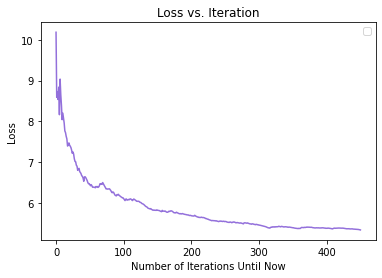

iteration # 901
iteration #901 10.096577670245585
iteration # 902
iteration #902 4.211943839046415
iteration # 903
iteration #903 4.561335392135709
iteration # 904
iteration #904 4.629770330014705
iteration # 905
iteration #905 5.120938804288486
iteration # 906
iteration #906 2.733346601635806
iteration # 907
iteration #907 5.107394599622113
iteration # 908
iteration #908 10.410997356808043
iteration # 909
iteration #909 3.824853500926322
iteration # 910
iteration #910 4.776533228546082
iteration # 911
iteration #911 3.2025404387123757
iteration # 912
iteration #912 4.662849513868281
iteration # 913
iteration #913 4.869589671170208
iteration # 914
iteration #914 4.458600593103726
iteration # 915
iteration #915 4.134212196660522
iteration # 916
iteration #916 4.671272484575777
iteration # 917
iteration #917 2.5096684769610547
iteration # 918
iteration #918 3.81603191839803
iteration # 919
iteration #919 3.5416577538502816
iteration # 920
iteration #920 2.3895620581149544
iteration # 921

No handles with labels found to put in legend.


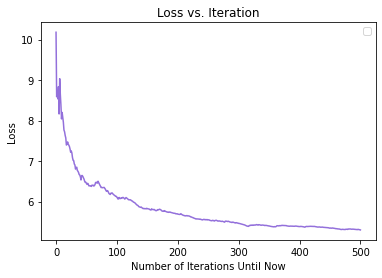

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


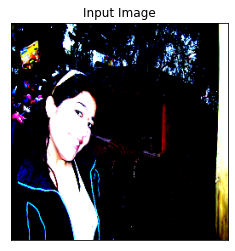

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


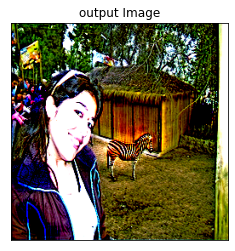

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


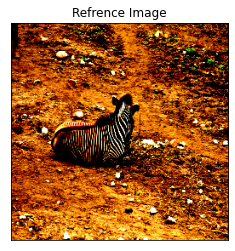

iteration # 1001
iteration #1001 3.2311094980727786
iteration # 1002
iteration #1002 3.2242101053866405
iteration # 1003
iteration #1003 3.8547078016623866
iteration # 1004
iteration #1004 4.51681910387067
iteration # 1005
iteration #1005 4.723750937106913
iteration # 1006
iteration #1006 4.607427097369606
iteration # 1007
iteration #1007 4.539038923856489
iteration # 1008
iteration #1008 6.767953418533356
iteration # 1009
iteration #1009 2.8008737701578568
iteration # 1010
iteration #1010 3.2798089577147524
iteration # 1011
iteration #1011 3.1338205204619163
iteration # 1012
iteration #1012 4.377820622091887
iteration # 1013
iteration #1013 4.616123061023759
iteration # 1014
iteration #1014 4.696961117403379
iteration # 1015
iteration #1015 2.3075606676262415
iteration # 1016
iteration #1016 5.3074802813503075
iteration # 1017
iteration #1017 2.2176953364229695
iteration # 1018
iteration #1018 4.220592040806769
iteration # 1019
iteration #1019 6.220810444730907
iteration # 1020
iterat

No handles with labels found to put in legend.


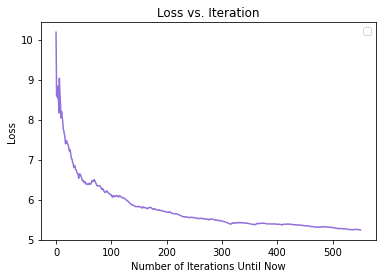

iteration # 1101
iteration #1101 2.6998107192664778
iteration # 1102
iteration #1102 5.385628378910464
iteration # 1103
iteration #1103 7.484110010909149
iteration # 1104
iteration #1104 3.2512998175917107
iteration # 1105
iteration #1105 4.543630306691755
iteration # 1106
iteration #1106 3.00478901362856
iteration # 1107
iteration #1107 2.394302959688102
iteration # 1108
iteration #1108 3.1007746139836745
iteration # 1109
iteration #1109 3.71591471957351
iteration # 1110
iteration #1110 9.213424291875837
iteration # 1111
iteration #1111 2.960392679537747
iteration # 1112
iteration #1112 4.410970435462797
iteration # 1113
iteration #1113 7.568132731171138
iteration # 1114
iteration #1114 5.394363078397562
iteration # 1115
iteration #1115 4.264012557059269
iteration # 1116
iteration #1116 6.459027960572968
iteration # 1117
iteration #1117 5.565992355967031
iteration # 1118
iteration #1118 3.2259109939548036
iteration # 1119
iteration #1119 2.8933876763306534
iteration # 1120
iteration #

No handles with labels found to put in legend.


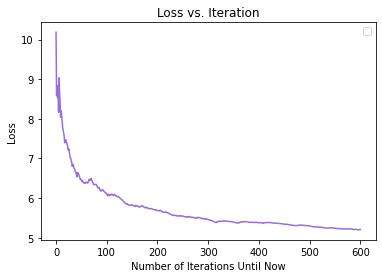

iteration # 1201
iteration #1201 6.832409258311049
iteration # 1202
iteration #1202 3.797232841755657
iteration # 1203
iteration #1203 4.458839458112617
iteration # 1204


In [ ]:
transNet.train()
losses = []
for epoch in range(num_epochs):
  print('Epoch %d has started......' %(epoch+1))
  iter_loss = 0
  
  for idx, (inputImg, refImg) in enumerate(train_loader):
    print('iteration #', idx)
    inputImg = Variable(inputImg).cuda()
    refImg  = Variable(refImg).cuda()
    content = inputImg
    style = refImg
    target = transNet(style, inputImg)

    contentFeatures = lossNet(content)
    styleFeatures = lossNet(style)
    targetFeatures = lossNet(target)

    contentLoss = torch.mean((contentFeatures['Conv4_2'] - targetFeatures['Conv4_2'])**2)
    stylLoss = calcStylLoss(targetFeatures, styleFeatures, styleWeights)
    reconstLoss =  F.mse_loss(target, content)

    totalLoss = perceptualCoeff*(contCoeff * contentLoss + stylCoeff * stylLoss) + reconstCoeff * reconstLoss
    iter_loss += totalLoss.item()
    print('iteration #' + str(idx), totalLoss.item())
    
    optimizer.zero_grad()
    totalLoss.backward()
    optimizer.step()
    
    if not idx % 2:
      
      torch.save(transNet, "./gdrive/MyDrive/Deep/transNet_checkpoint.pth.tar")

      losses.append(iter_loss/(idx+1))

    if not idx % 100:
      plt.plot(losses, color='mediumpurple')
      plt.title('Loss vs. Iteration')
      plt.xlabel('Number of Iterations Until Now')
      plt.ylabel('Loss')
      plt.legend(loc='best')
      plt.show()

    if not idx % 250:
      a = inputImg[0].cpu().detach().numpy()
      b = target[0].cpu().detach().numpy()
      c = refImg[0].cpu().detach().numpy()

      plt.imshow(np.transpose(a, (1,2,0)))
      plt.title('Input Image')
      plt.xticks(())
      plt.yticks(())
      plt.show()

      plt.imshow(np.transpose(b, (1,2,0)))
      plt.title('output Image')
      plt.xticks(())
      plt.yticks(())
      plt.show()

      plt.imshow(np.transpose(c, (1,2,0)))
      plt.title('Refrence Image')
      plt.xticks(())
      plt.yticks(())
      plt.show()

      
